<a name="lib"></a>

# Import libraries and packages

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

try:
  from tiingo import TiingoClient
except:
  !pip install tiingo
  from tiingo import TiingoClient

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Import Dataset

In [2]:
config = {}

# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True

# pass it in via a configuration dictionary.
config['api_key'] = "e53de50416acf81900ce551794fe0b05368afa4a"

# Initialize
client = TiingoClient(config)

In [3]:
# Get Ticker
ticker_metadata = client.get_ticker_metadata("AMZN")

# Get historical AMZN prices from August 2017 as JSON, sampled daily
AMZN = client.get_dataframe("AMZN",
                            fmt='json',
                            startDate='2012-08-01',
                            endDate='2022-01-10',
                            frequency='daily')

In [4]:
AMZN.reset_index(inplace=True)

In [5]:
AMZN.to_csv('AMZN.csv')

In [6]:
AMZN.head(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


In [7]:
maindf = pd.read_csv('AMZN.csv')
maindf = maindf.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low',
                                'Close':'close', 'Adj Close':'adj_close', 'Adj High': 'adjHigh',
                                'Adj Low': 'adjLow', 'Adj Open': 'adjOpen',
                                'Div Cash': 'divCash', 'Split Factor': 'splitFactor',
                                'Adj Volume':'adjVolume'})
maindf.head()

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


In [8]:
maindf.drop(columns=maindf.columns[0], axis=1, inplace=True)

In [9]:
maindf.head(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


In [10]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  2377
Total number of fields:  13


<a name="na"></a>

# Checking Null and NA value

In [11]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


<a name="predate"></a>

# Convert Date field into datetime format

In [12]:
# convert date field from string to Date format
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


<a name="eda"></a>

# EDA - Exploratory Data Analysis

<a name="dur"></a>

### Find the duration of dataset

In [13]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2012-08-01 00:00:00+00:00
Ending date:  2022-01-10 00:00:00+00:00
Duration:  3449 days 00:00:00


<a name="oc"></a>

### Monthwise comparision between Stock open and close price

In [14]:
monthwise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,open,close
date,,
January,1214.741830,1215.052133
February,1192.118750,1191.633140
March,1197.995202,1198.504426
April,1265.421506,1266.445117
May,1292.561419,1292.150289
June,1372.380990,1373.339781
July,1475.869914,1476.220240
August,1328.835896,1329.532480
September,1365.052475,1361.884921


In [15]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

<a name="hl"></a>

### Monthwise High and Low stock price

In [16]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthwise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

<a name="trend"></a>

### Trend comparision between stock open price, close price, high price, low price

In [17]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'],
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<a name="sc"></a>

**Here, We are going to predict close price for next 30 days**

# Prepare Stock Close price

<a name="df"></a>

### Make separate dataframe of close price

In [18]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2377, 2)


<a name="pclose"></a>

### Plotting Stock Close price chart

In [19]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="year"></a>

# Consider only last 1 year data for prediction

In [20]:
closedf = closedf[closedf['date'] > '2020-08-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  354


In [21]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="norm"></a>

### Normalizing close price

In [22]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(354, 1)


<a name="split"></a>

### Prepare Data for train and test

In [23]:
training_size=int(len(closedf)*0.85)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (300, 1)
test_data:  (54, 1)


<a name="trans"></a>

### Transform Close price base on Time-series-analysis forecasting requirement

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (284, 15)
y_train:  (284,)
X_test:  (38, 15)
y_test (38,)


In [26]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (284, 15, 1)
X_test:  (38, 15, 1)


In [27]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(24, activation = 'relu', return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.05))
model.add(GRU(32, activation = 'relu', return_sequences=True))
model.add(Dropout(0.10))
model.add(GRU(64, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 24)            1944      
                                                                 
 dropout (Dropout)           (None, 15, 24)            0         
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            5568      
                                                                 
 dropout_1 (Dropout)         (None, 15, 32)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=24,verbose=1)

<a name="loss"></a>

### Plotting loss chart

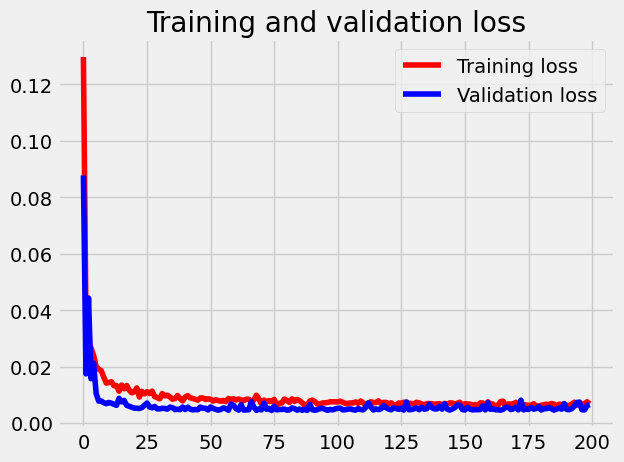

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [31]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 8ms/step


((284, 1), (38, 1))

<a name="eval"></a>

# Model Evaluation

In [32]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

<a name="mse"></a>

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [33]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  59.675419433445555
Train data MSE:  3561.1556845576515
Train data MAE:  47.07587199466332
-------------------------------------------------------------------------------------
Test data RMSE:  63.01447121227941
Test data MSE:  3970.82358216319
Test data MAE:  46.857107319078835


<a name="var"></a>

### Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [34]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.8812593444471765
Test data explained variance regression score: 0.7290887372621138


<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

In [35]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.859837785559775
Test data R2 score: 0.6173038315670865


<a name="mpd"></a>

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [36]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0003340324024346136
Test data MGD:  0.00033426437470023506
----------------------------------------------------------------------
Train data MPD:  1.089415589999298
Test data MPD:  1.1516621610201008


<a name="cp"></a>

# Comparision of original stock close price and predicted close price

In [37]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (354, 1)
Test predicted data:  (354, 1)


<a name="days"></a>

# Predicting next 30 days

In [38]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


<a name="pdays"></a>

### Plotting last 15 days of dataset and next predicted 30 days

In [39]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [40]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="pwhole"></a>

### Plotting entire Closing Stock Price with next 30 days period of prediction

In [41]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()